In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 18.1MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 17.4MB/s 


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-03-01 11:27:25--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-03-01 11:27:25--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd4e8a1125611426a42ae6f0803.dl.dropboxusercontent.com/cd/0/get/BJ0N346gSBusVNn0W6lNwf5dMRTZtO-H1EtIRbi6MtzwxSc-MFe5ikFhmpBqW2-7tEYGLfzOOel_RqwykQARRPVxD9qmRjcFiPVb9nlWbfM1xuo9wbbT4ePOtWILkJtcfhw/file?dl=1# [following]
--2021-03-01 11:27:26--  https://ucd4e8a1125611426a42ae6f0803.dl.dropboxusercontent.com/cd/0/get/BJ0N346gSBusVNn0W6lNwf5dMRTZtO-H1EtIRbi6MtzwxSc-MFe5ikFhmpBqW2-7tEYGLfzOOel_RqwykQARRPVxD9qmRjcFiPVb9nlWbfM1xuo9wbbT4ePOtWIL

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='hrnet_w48'),
]

In [9]:
import timm
timm.list_models('*hrnet_w48*')

['hrnet_w48']

In [10]:
learn = Learner(dls512, timm.models.hrnet.hrnet_w48(num_classes=2),cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-hrnet/hrnetv2_w48-abd2e6ab.pth" to /root/.cache/torch/hub/checkpoints/hrnetv2_w48-abd2e6ab.pth


SuggestedLRs(lr_min=0.2290867567062378, lr_steep=1.9054607152938843)

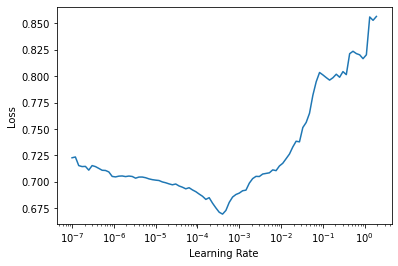

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.693467,0.672787,0.585627,0.554023,0.757862,01:21


Better model found at epoch 0 with valid_loss value: 0.67278653383255.


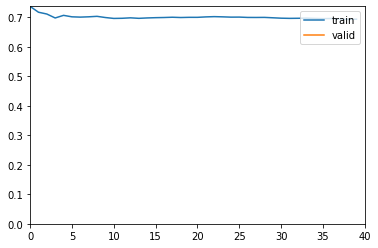

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.665059,0.665926,0.605505,0.575000,0.723270,01:20
1,0.660189,0.657870,0.626911,0.594388,0.732704,01:20
2,0.650685,0.641649,0.645260,0.619444,0.701258,01:20
3,0.630564,0.614326,0.694190,0.664804,0.748428,01:20
4,0.599100,0.573600,0.717125,0.723906,0.676101,01:20
5,0.558380,0.564672,0.715596,0.706250,0.710692,01:20
6,0.517525,0.556079,0.727829,0.750000,0.660377,01:20
7,0.475963,0.561840,0.723242,0.742049,0.660377,01:20
8,0.435323,0.573232,0.724771,0.724026,0.701258,01:20
9,0.399279,0.596176,0.726300,0.729373,0.694969,01:19


Better model found at epoch 0 with valid_loss value: 0.665926456451416.


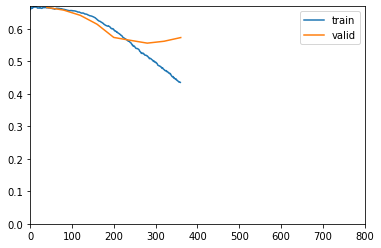

Better model found at epoch 1 with valid_loss value: 0.6578704714775085.
Better model found at epoch 2 with valid_loss value: 0.6416494846343994.
Better model found at epoch 3 with valid_loss value: 0.6143264770507812.
Better model found at epoch 4 with valid_loss value: 0.5735999345779419.
Better model found at epoch 5 with valid_loss value: 0.5646718740463257.
Better model found at epoch 6 with valid_loss value: 0.5560793280601501.
No improvement since epoch 6: early stopping


In [12]:
learn.fine_tune(20,base_lr=1e-5)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

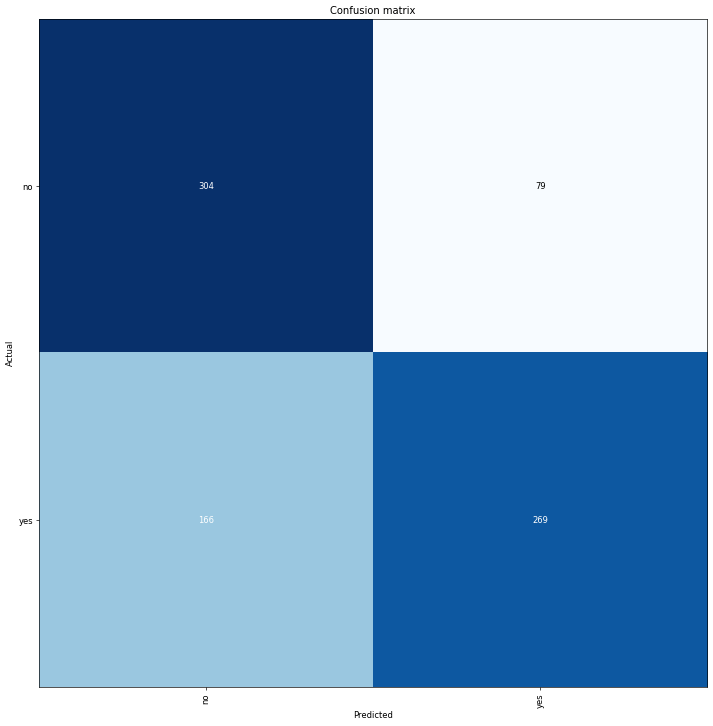

In [14]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7004889845848083.


(#4) [0.5702968835830688,0.7004889845848083,0.7729885057471264,0.6183908045977011]

In [16]:
learn.export(fname='hrnet48.pkl')